## Model inference

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
# project_root = "."
if project_root not in sys.path:
    sys.path.append(project_root)
# Set the environment variables from the file <root_dir>/.env
from backend.models import config
settings = config.HopsworksSettings(_env_file=f"{project_root}/.env")

HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from backend import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 15, 15, 33, 16, 867613)

### Initialize project and retrieve model

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

2025-11-15 15:33:16,901 INFO: Initializing external client
2025-11-15 15:33:16,902 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 15:33:17,620 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 15:33:18,393 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279162


In [5]:
country = locals().get("country", settings.AQICN_COUNTRY)
city = locals().get("city", settings.AQICN_CITY)
street = locals().get("street", settings.AQICN_STREET)
lag_feature = locals().get("lag_feature", "pm25_lag_3")

In [7]:
street_new = street.replace('-', '_')
street_new = street_new.replace('ä', 'ae')
street_new = street_new.replace('ö', 'oe')
street_new = street_new.replace('å', 'oa')

In [8]:
print(street)

nacka


In [9]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model" + "_" + lag_feature + "_"  + country + "_" + city + "_" + street_new,
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-15 15:33:22,898 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/481346 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112004 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21485 elapsed<00:00 remaining<?

In [10]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model" + "_"  + country + "_" + city + "_" + street_new + ".json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.393543E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_with_all_lags',
    version=1,
)

In [12]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [13]:
aq_hist: pd.DataFrame = air_quality_fg.read()
aq_hist["date"] = pd.to_datetime(aq_hist["date"]).dt.tz_localize(None)

aq_loc = aq_hist[
    (aq_hist["country"] == country) &
    (aq_hist["city"] == city) &
    (aq_hist["street"] == street)
].sort_values("date")

aq_loc.tail(5).head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


,date,pm25,country,city,street,url,pm25_rolling_3d,pm25_rolling_2d,pm25_lag_1,pm25_lag_2,pm25_lag_3
18501,2025-11-11,1.40,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,4.573334,1.850,0.80,2.90,10.02
18824,2025-11-12,2.37,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.700000,1.100,1.40,0.80,2.90
18696,2025-11-13,0.90,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.523333,1.885,2.37,1.40,0.80
25273,2025-11-14,2.00,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.556667,1.635,0.90,2.37,1.40
25286,2025-11-15,2.00,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.756667,1.450,2.00,0.90,2.37


In [14]:
if lag_feature == 'pm25':
    weather_all = weather_fg.filter(weather_fg.date >= today).read()
    weather_all["date"] = pd.to_datetime(weather_all["date"]).dt.tz_localize(None)
    batch_data = weather_all[
        (weather_all["city"] == city)
    ].copy()
    batch_data = batch_data.sort_values("date").reset_index(drop=True)
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    batch_data
else:
    batch_data = util.predict_pm25_with_single_feature(
        model=retrieved_xgboost_model,
        weather_fg=weather_fg,
        air_quality_fg=air_quality_fg,
        country=country,
        city=city,
        street=street,
        today=today,
        feature_name=lag_feature
    )
    batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 
[0.8999999761581421, 2.0, 2.0]
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 
0.8999999761581421
2.420695
[2.0, 2.0, 2.420695]
2.0
1.6139848
[2.0, 2.420695, 1.6139848]
2.0
5.662271
[2.420695, 1.6139848, 5.662271]
2.420695
5.276436
[1.6139848, 5.662271, 5.276436]
1.6139848
4.302544
[5.662271, 5.276436, 4.302544]
5.662271
2.4583552
[5.276436, 4.302544, 2.4583552]


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         6 non-null      datetime64[ns]
 1   temperature_2m_mean          6 non-null      float32       
 2   precipitation_sum            6 non-null      float32       
 3   wind_speed_10m_max           6 non-null      float32       
 4   wind_direction_10m_dominant  6 non-null      float32       
 5   city                         6 non-null      object        
 6   predicted_pm25               6 non-null      float32       
dtypes: datetime64[ns](1), float32(5), object(1)
memory usage: 348.0+ bytes


In [16]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-16,3.05,0.0,9.511088,240.524200,stockholm,2.420695,nacka,sweden,1
1,2025-11-17,0.20,0.0,11.720751,317.489594,stockholm,1.613985,nacka,sweden,2
2,2025-11-18,0.15,0.0,6.638072,282.528809,stockholm,5.662271,nacka,sweden,3
3,2025-11-19,-0.05,0.0,6.519877,353.659912,stockholm,5.276436,nacka,sweden,4
4,2025-11-20,1.80,0.4,6.618519,22.380184,stockholm,4.302544,nacka,sweden,5
5,2025-11-21,1.20,0.0,13.320000,360.000000,stockholm,2.458355,nacka,sweden,6


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         6 non-null      datetime64[ns]
 1   temperature_2m_mean          6 non-null      float32       
 2   precipitation_sum            6 non-null      float32       
 3   wind_speed_10m_max           6 non-null      float32       
 4   wind_direction_10m_dominant  6 non-null      float32       
 5   city                         6 non-null      object        
 6   predicted_pm25               6 non-null      float32       
 7   street                       6 non-null      object        
 8   country                      6 non-null      object        
 9   days_before_forecast_day     6 non-null      int64         
dtypes: datetime64[ns](1), float32(5), int64(1), object(3)
memory usage: 492.0+ bytes


### Create Forecast Graph

2025-11-15 15:33:35,033 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



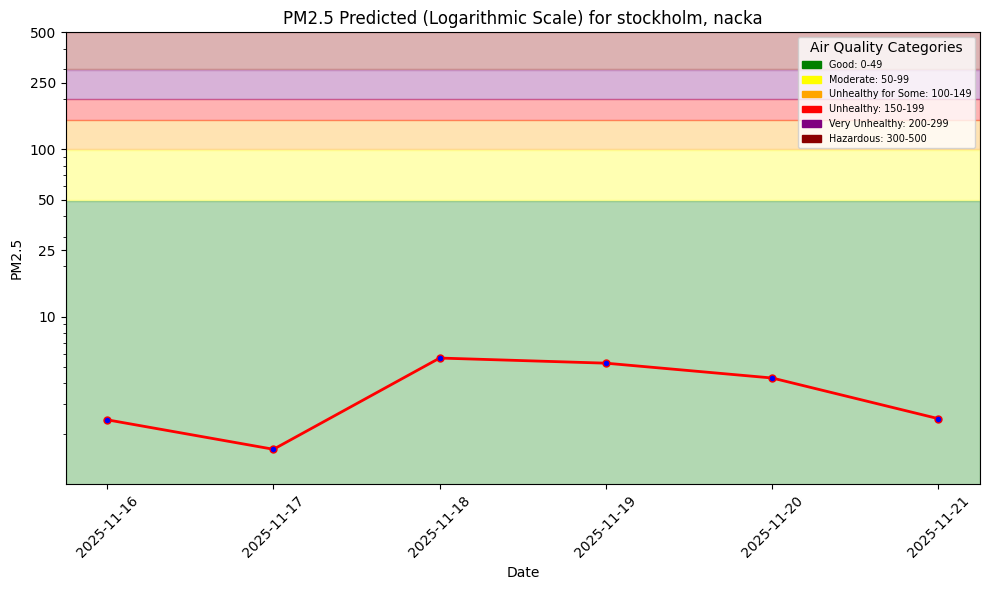

In [18]:
model_dir = f"{project_root}/backend/air_quality_models/" + (lag_feature + "/" + country + "_" + city + "_" + street_new)
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)
pred_file_path = model_dir + "/predictions"
if not os.path.exists(pred_file_path):
    os.mkdir(pred_file_path)
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path + "/pm25_forecast.png")
plt.show()

### Create hindcast graph

In [19]:
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{lag_feature}',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [20]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_pm25_lag_3_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279162/jobs/named/aq_predictions_pm25_lag_3_1_offline_fg_materialization/executions
2025-11-15 15:33:53,943 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 15:34:00,269 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


KeyboardInterrupt: 

In [ ]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,3.05,0.0,9.511088,240.5242,stockholm,1.160889,ljusslingan,sweden,1
1,2025-11-16 00:00:00+00:00,3.05,0.0,9.511088,240.5242,stockholm,2.185056,nacka,sweden,1


In [ ]:
air_quality_df = air_quality_fg.read()[
        (aq_hist["country"] == country) &
        (aq_hist["city"] == city) &
        (aq_hist["street"] == street)
]
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.06s) 


,date,pm25,country,city,street,url,pm25_rolling_3d,pm25_rolling_2d,pm25_lag_1,pm25_lag_2,pm25_lag_3
18005,2022-10-14 00:00:00+00:00,7.39,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.250000,1.435,1.97,0.900000,0.88
18006,2022-04-15 00:00:00+00:00,0.60,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,2.310000,2.930,4.76,1.100000,1.07
18007,2023-12-21 00:00:00+00:00,1.67,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.716667,1.825,2.70,0.950000,1.50
18008,2025-03-08 00:00:00+00:00,2.40,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,2.796667,2.795,2.67,2.920000,2.80
18009,2023-12-25 00:00:00+00:00,1.70,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.483333,1.525,1.55,1.500000,1.40
...,...,...,...,...,...,...,...,...,...,...,...
19664,2023-02-07 00:00:00+00:00,4.40,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.333333,1.485,1.80,1.170000,1.03
19665,2023-02-06 00:00:00+00:00,1.80,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.266667,1.100,1.17,1.030000,1.60
19666,2025-02-23 00:00:00+00:00,15.80,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,16.033333,23.350,29.67,17.030001,1.40
25273,2025-11-14 00:00:00+00:00,2.00,sweden,stockholm,nacka,https://api.waqi.info/feed/A196735,1.556667,1.635,0.90,2.370000,1.40


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']].copy()
outcome_df["date"] = pd.to_datetime(outcome_df["date"]).dt.tz_localize(None)
preds_df =  monitoring_df[['date', 'predicted_pm25']].copy()
preds_df["date"] = pd.to_datetime(preds_df["date"]).dt.tz_localize(None)

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

no_outcomes = (len(hindcast_df) == 0)

In [ ]:
if not no_outcomes:
    hindcast_file_path = pred_file_path + "/pm25_hindcast_1day.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

### Upload prediction and hindcast to Hopsworks

In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
if dataset_api.exists(f"Resources/airquality/{lag_feature}") == False:
    dataset_api.mkdir(f"Resources/airquality/{lag_feature}")
if dataset_api.exists(f"Resources/airquality/{lag_feature}/{country}_{city}_{street}") == False:
    dataset_api.mkdir(f"Resources/airquality/{lag_feature}/{country}_{city}_{street}")
if dataset_api.exists(f"Resources/airquality/{lag_feature}/{country}_{city}_{street}/{str_today}") == False:
    dataset_api.mkdir(f"Resources/airquality/{lag_feature}/{country}_{city}_{street}/{str_today}")
dataset_api.upload(pred_file_path + "/pm25_forecast.png", f"Resources/airquality/{lag_feature}/{country}_{city}_{street}/{str_today}", overwrite=True)
if not no_outcomes:
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{lag_feature}/{country}_{city}_{street}/{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

KeyboardInterrupt: 